In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("BMSDETAILDAY1 - Sheet1 (1).csv")

In [3]:
df.head()

,BookingNumber,BrandCode,ProgramCode,TapeCode,TapeDuration,ScheduleDate,SpotRate,StartTime,EndTime
0,18101001S,INMOK00001,INBHA00046,INMOK00015,10,2018-10-01 0:00:00,200.0,NaN,NaN
1,18101001S,INMOK00001,INBHA00046,INMOK00016,15,2018-10-01 0:00:00,200.0,NaN,NaN
2,18101001S,INMOK00001,INBHA00046,INMOK00017,15,2018-10-01 0:00:00,200.0,NaN,NaN
3,18101001S,INMOK00001,INPRA00027,INMOK00015,10,2018-10-01 0:00:00,200.0,NaN,NaN
4,18101001S,INMOK00001,INPRA00027,INMOK00016,15,2018-10-01 0:00:00,200.0,NaN,NaN


In [4]:
df['IsActive']=int(1)
df['Scheduled']=int(0)
df['Priority']=int(1)
df['Held_Back_Value']=0

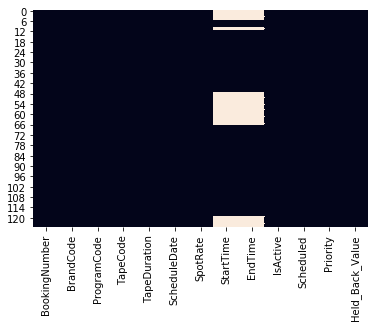

In [6]:
sns.heatmap(df.isnull(), cbar=False)

In [8]:
df=df.fillna('1899-12-03 00:00:00')

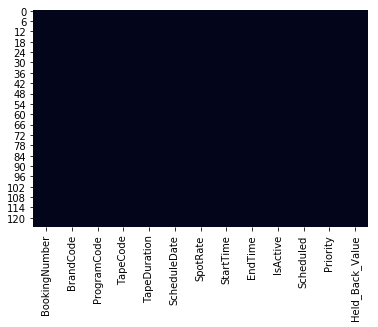

In [9]:
sns.heatmap(df.isnull(), cbar=False)

In [11]:
df['StartTime'][6]

'1899-12-30 7:00:00'

In [12]:
from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta

In [14]:
df['StartTime']=(df['StartTime'].astype('str')).str.split(" ")

In [15]:
df['MDStartTime']=df['StartTime'].apply(lambda x : x[-1:])

In [16]:
df['EndTime']=(df['EndTime'].astype('str')).str.split(" ")

In [17]:
df['MDEndTime']=df['EndTime'].apply(lambda x : x[-1:])

In [18]:
x=df['MDEndTime']
x=x.apply(lambda x : x[0])

In [19]:
df['MDEndTime']=x

In [20]:
x=df['MDStartTime']
x=x.apply(lambda x : x[0])
df['MDStartTime']=x

In [21]:
len(str(df['MDEndTime'][0]))

8

In [22]:
def mdtime(x):
    y=timedelta(seconds=0)
    leng=len(str(x))
    s1=int(x[leng-1])
    s2=int(x[leng-2])
    y=y+timedelta(seconds=s1+s2*10)
    m1=int(x[leng-4])
    m2=int(x[leng-5])
    y=y+timedelta(minutes=m1+m2*10)
    h1=int(x[leng-7])
    if leng>7:
        h2=int(x[leng-8])
    else: 
        h2=0
    y=y+timedelta(hours=h1+h2*10)
    return y
df['MDEndTime']=df['MDEndTime'].apply(mdtime)
df['MDStartTime']=df['MDStartTime'].apply(mdtime)
    

In [23]:
CurrentClock=timedelta(seconds=0)

In [24]:
MaximumClock=timedelta(days=1)

In [25]:
global j

def startup():
    a=2
    global df
    global finallog
    finallog=pd.DataFrame(columns=('CurrentTime','BookingNumber','Duration','BrandCode','TapeCode'))
    j=0
    print("Enter the time you want to start scheduling from in seconds, minutes and hours")
    s=int(input())
    m=int(input())
    h=int(input())
    CurrentClock=timedelta(seconds=s,minutes=m,hours=h)
    while (CurrentClock<MaximumClock):
        print("Enter the program segment's program code and duration in mins and seconds")
        CurrentProgramCode=str(input())
        m=int(input())
        s=int(input())
        df_2=pd.DataFrame(data={'CurrentTime':[CurrentClock],'BookingNumber':[""],'Duration':[timedelta(seconds=s, minutes=m)],'BrandCode':[""],'TapeCode':[CurrentProgramCode]})
        finallog=pd.concat([finallog,df_2],axis=0)
        print(finallog)
        CurrentClock=CurrentClock+timedelta(seconds=s,minutes=m)
        print("Enter the break duration in seconds")
        break_time=int(input())
        Newbreak(CurrentProgramCode)
        limit=CurrentClock+timedelta(seconds=break_time)
        while(CurrentClock<limit):
            Prioritize()
            sort()
            a, tempdf=addadv(CurrentClock)
            if(a==1):
                CurrentClock=CurrentClock+pd.Timedelta(seconds=df['TapeDuration'][1])
                df=df.iloc[1:]
                df.reset_index(drop=True, inplace=True)
                pd.concat([finallog,tempdf],axis=0)
            if(a==0): break 
    print("Day scheduling is over")        
            

In [26]:
def Newbreak(CurrentProgramCode):
    x=np.ones(len(df))
    y=np.ones(len(df))*0
    i=0
    for row in df.iterrows():
        if(row[1]['IsActive']==0): 
            y=0
        else: 
            y=((row[1]['Held_Back_Value'])*6+1)/6  #heldbackvalue
        if(str(row[1]['ProgramCode'])!=CurrentProgramCode):
            x[i]=0
        if(row[1]['MDStartTime']!=row[1]['MDEndTime']):
            if(CurrentClock<row[1]['MDStartTime'] or CurrentClock>row[1]['MDEndTime']):
                x[i]=0
        i+=1
    df['IsActive'].iloc[0:]=x[0:]
    df['Held_Back_Value'].iloc[0:]=y
    #print(df['Held_Back_Value'],y)

In [27]:
df.head()

,BookingNumber,BrandCode,ProgramCode,TapeCode,TapeDuration,ScheduleDate,SpotRate,StartTime,EndTime,IsActive,Scheduled,Priority,Held_Back_Value,MDStartTime,MDEndTime
0,18101001S,INMOK00001,INBHA00046,INMOK00015,10,2018-10-01 0:00:00,200.0,"[1899-12-03, 00:00:00]","[1899-12-03, 00:00:00]",1,0,1,0,0 days,0 days
1,18101001S,INMOK00001,INBHA00046,INMOK00016,15,2018-10-01 0:00:00,200.0,"[1899-12-03, 00:00:00]","[1899-12-03, 00:00:00]",1,0,1,0,0 days,0 days
2,18101001S,INMOK00001,INBHA00046,INMOK00017,15,2018-10-01 0:00:00,200.0,"[1899-12-03, 00:00:00]","[1899-12-03, 00:00:00]",1,0,1,0,0 days,0 days
3,18101001S,INMOK00001,INPRA00027,INMOK00015,10,2018-10-01 0:00:00,200.0,"[1899-12-03, 00:00:00]","[1899-12-03, 00:00:00]",1,0,1,0,0 days,0 days
4,18101001S,INMOK00001,INPRA00027,INMOK00016,15,2018-10-01 0:00:00,200.0,"[1899-12-03, 00:00:00]","[1899-12-03, 00:00:00]",1,0,1,0,0 days,0 days


In [29]:
maxsp=df['SpotRate'].max()
minsp=df['SpotRate'].min()

In [30]:
normalize = lambda x : (x-minsp)/(maxsp-minsp)

C:\Users\Joel\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


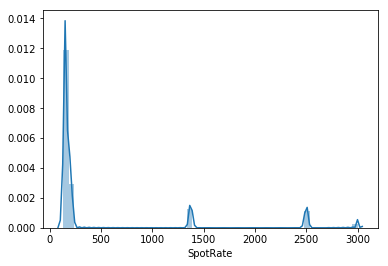

In [32]:
sns.distplot(df['SpotRate'], 50, True)

In [33]:
KMeanCentres=np.array([1/6,0.5,5/6])

In [34]:
from sklearn.cluster import KMeans
kmeans=KMeans(3,'k-means++',15,300)

In [35]:
spotrate=np.array(normalize(df['SpotRate']))
spotrate=spotrate.reshape(-1,1)
pred=kmeans.fit(spotrate)

In [36]:
centspr=kmeans.cluster_centers_
centpri=KMeanCentres

In [37]:
CentCoord=np.ones((9,2),dtype=np.complex_)
a=0
for i in centpri:
    for j in centspr:
        CentCoord[a][0]=i
        CentCoord[a][1]=j
        a=a+1

In [42]:
import math
def Prioritize():
    temp=np.zeros(9)
    x=np.ones(len(df))
    j=0
    for rows in df.iterrows():
        i=0
        while(i<9):
            temp[i]=(((float(CentCoord[i][0])-float(rows[1][12]))**2+(float(CentCoord[i][1])-float(normalize(rows[1][6]))**2)))
            i+=1
        tmp=temp.min()
        for num,tup in enumerate(temp):
            if tup==tmp: x[j]=num
        j+=1
    df['Priority']=x
def sort():
    df.sort_values(by=['IsActive','Priority'],ascending=False,inplace=True)
    df.reset_index(drop=True,inplace=True)

In [64]:
def addadv(CurrentClock):
    x=np.ones(len(df))
    if(df['IsActive'][0]==1):# IS NOT GETTING SATISFIED AT ALL ALL ISACTIVE 0
        #tempdf=pd.DataFrame(columns=('CurrentTime','BookingNumber','Duration','BrandCode','TapeCode')
        #tempdf=tempdf.append(pd.Series([CurrentClock,df['BookingNumber'][0],pd.Timedelta(seconds=df['TapeDuration'][0]),df['BrandCode'][0],df['TapeCode'][0]]))
        tempdf=pd.DataFrame(data={'CurrentTime':[CurrentClock],'BookingNumber':[df['BookingNumber'][0]],'Duration':[timedelta(seconds=int(df['TapeDuration'][0]))],'BrandCode':[df['BrandCode'][0]],'TapeCode':[df['TapeCode'][0]]})
        print(tempdf)
        i=0
        for row in df.iterrows():
            if (row[1]['BrandCode']==df['BrandCode'][0]):
                x[i]=0
            elif (row[1]['IsActive']==1):
                x[i]=1
            i+=1
        df['IsActive'].iloc[0:]=x[0:]
#       for i in range(1,len(df)):
#            if(df['IsActive'][i]==1 and x[i]==1):
#                temp=1 
#            else: 
#                temp=0
#            df['IsActive'].iloc[i]=temp
#         print(df['IsActive'].iloc[i])
        pd.concat([finallog,tempdf])
        return 1, tempdf
    else:print('Ads exhausted for this break') 
    return 0, None

In [ ]:
#startup()